# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import time
import copy as cp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    ######usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 122)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
sample_size_base = 30000
sample_size_grid = 10000
data_clean = data_application_train[:sample_size_base].copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

- The `training set` is used to train various models.
- The `validation set` is used to select a model: we choose the one with the best performance on this set.
- The `test set` is used to estimate the generalization performance of the selected model.

Alternatively, instead of creating those three sets, we can separate the data into only two parts: a `training set` and a `test set` and then do a cross-validation on the `training set`. This allows us to choose a model (the one with the best performance), which we will then train on the whole `training set` and test on the `test set`. It is this final performance that is the best approximation of the performance that the model will be able to achieve on new data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
#X_train_full, X_test, y_train_full, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.10,
                                                random_state=0,
                                                stratify=Y_full)

### Encoding the qualitative variables

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [11]:
#oe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() == 2]
#ohe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() > 2]

oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [12]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [13]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [14]:
#X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train = transform_labels(X_train, oe_model, ohe_model)
#X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [16]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [17]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [18]:
#X_train_full = impute(X_train_full, imputer_model)
X_train = impute(X_train, imputer_model)
#X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

(27000, 242) <class 'pandas.core.frame.DataFrame'>
(3000, 242) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

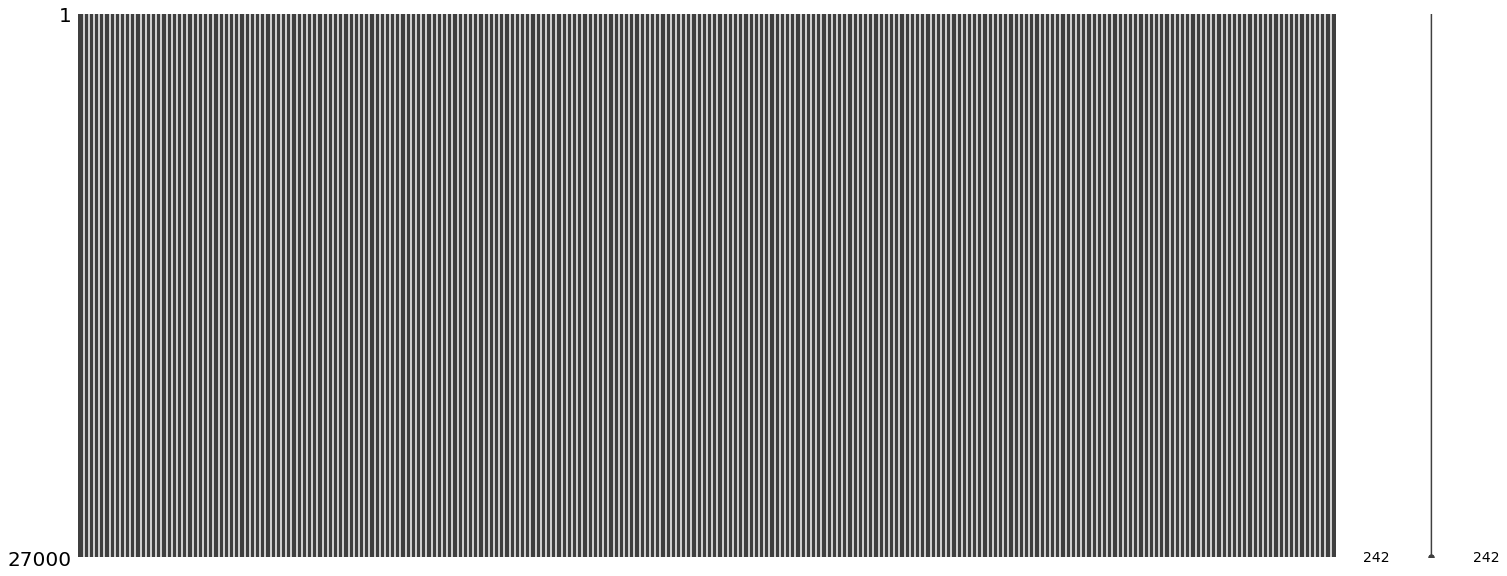

In [19]:
msno.matrix(X_train)

### Normalizing the dataset

In [20]:
from sklearn.preprocessing import RobustScaler

In [21]:
def fit_normalizer(data):
       
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [22]:
model_scaler = fit_normalizer(X_train)

In [23]:
#X_train_full = normalize(X_train_full, model_scaler)
X_train = normalize(X_train, model_scaler)
#X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

### Define some report functions

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [25]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [26]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [27]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [28]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- PRECISION RECALL AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.5)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [29]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        #X_ref = X_valid
        X_ref = X_test
        
    if y_ref is None:
        #y_ref = y_valid
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)

    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
        
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        threshold = threshold if threshold else 0.5
        idx = np.where(scores_df.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores_df.index)
        scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]
        
        scores_df.to_csv(scores_path, index=False)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
    print(f"--- {method_name} ---\n\n{scores_str}")
          
    
    if simple:
        return
    
    print('-'*100,'The informations below this line are based on the best estimator of the cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [30]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [31]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [32]:
#from sklearn.experimental import enable_halving_search_cv
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV
from collections import defaultdict

def fit_model(model, X_ref=None, y_ref=None, param_grid = {}, scoring={'roc_auc', 'precision', 'recall', 'f1', 'accuracy', 'average_precision'}, cv=5, verbose=2):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500)
    grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time
    
    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = " | ".join([ f"{scorer}: {results[f'split{i}_{sample}_{scorer}'].mean():.4f}" for scorer in scoring])
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()} SET MEAN SCORES ".center(100,'-'))
            mean_str = " \n - ".join([ f"{scorer}: {results[f'mean_{sample}_{scorer}'].mean():.4f} (std:{results[f'std_{sample}_{scorer}'].mean():.4f})" for scorer in scoring])
            print(f"\n - {mean_str}")
            
        print("\n", f"".center(100,'-'))
        
    scores_args = defaultdict(list)
    for scorer in scoring:
        scores_args[scorer] = results[f'mean_test_{scorer}'].mean()             
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid, **scores_args}

In [33]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [34]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [35]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[0], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=1,
)


 --------------------------------------- TEST SET MEAN SCORES ---------------------------------------

 - f1: 0.0830 (std:0.0146) 
 - recall: 0.0846 (std:0.0148) 
 - roc_auc: 0.5008 (std:0.0081) 
 - accuracy: 0.8503 (std:0.0023) 
 - average_precision: 0.0804 (std:0.0014) 
 - precision: 0.0815 (std:0.0143)

 ----------------------------------------------------------------------------------------------------


--- DummyClassifier ---

                  F1 : 0.0830
              RECALL : 0.0846
             ROC_AUC : 0.5008
            ACCURACY : 0.8503
   AVERAGE_PRECISION : 0.0804
           PRECISION : 0.0815

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.90      0.91      2760
Prediction = 1       0.06      0.07      0.07       240

      accuracy                           0.84      3000
     macro avg       0.49      0.49      0.49      3000
  weighted avg       0.85      0.84      0.84      3000

--- Confusion Matrix ---



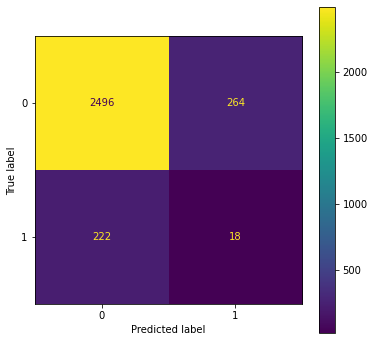

--- ROC AUC ---



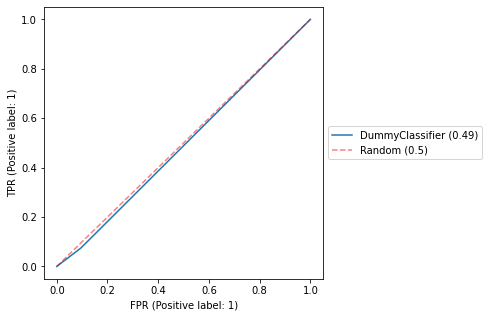

--- PRECISION RECALL AUC ---



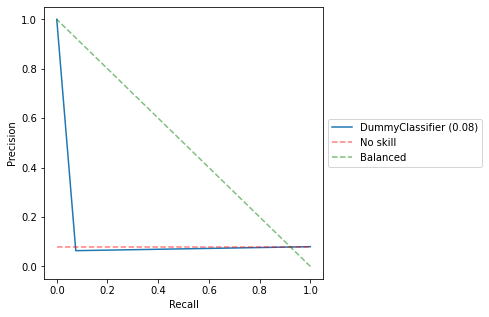

In [38]:
get_scores(get_model_name(grd_dummy['model']), **grd_dummy, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid={ 'random_state':[0], 'max_iter':[3000] },  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | f1: 0.0225 | recall: 0.0116 | roc_auc: 0.7387 | accuracy: 0.9194 | average_precision: 0.2020 | precision: 0.3846
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | f1: 0.0315 | recall: 0.0162 | roc_auc: 0.7326 | accuracy: 0.9202 | average_precision: 0.2041 | precision: 0.5385
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | f1: 0.0315 | recall: 0.0162 | roc_auc: 0.7195 | accuracy: 0.9202 | average_precision: 0.1936 | precision: 0.5833
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | f1: 0.0179 | recall: 0.0092 | roc_auc: 0.7346 | accuracy: 0.9185 | average_precision: 0.2153 | precision: 0.2667
----------------------------------------------------

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Basic LogisticRegression ---

                  F1 : 0.0286
              RECALL : 0.0148
             ROC_AUC : 0.7337
            ACCURACY : 0.9196
   AVERAGE_PRECISION : 0.2070
           PRECISION : 0.4446

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



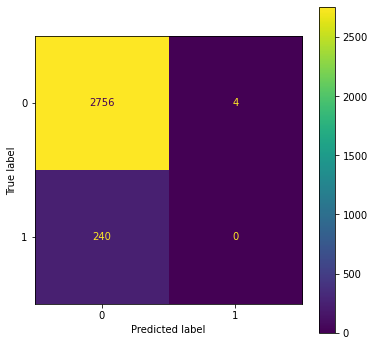

--- ROC AUC ---



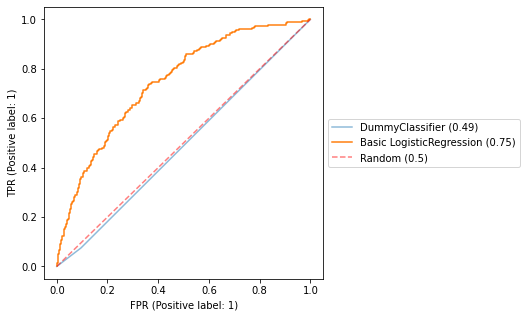

--- PRECISION RECALL AUC ---



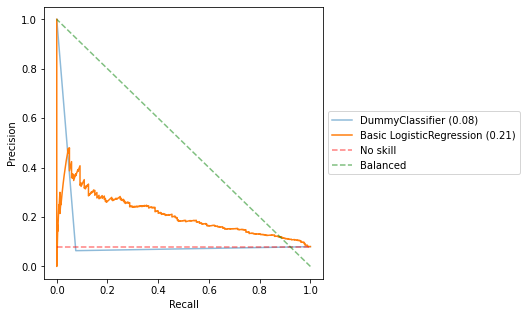

In [41]:
get_scores(f"Basic {get_model_name(grd_log['model'])}", **grd_log, register=True)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | f1: 0.1456 | recall: 0.1574 | roc_auc: 0.5350 | accuracy: 0.8522 | average_precision: 0.0887 | precision: 0.1355
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | f1: 0.1398 | recall: 0.1505 | roc_auc: 0.5317 | accuracy: 0.8519 | average_precision: 0.0876 | precision: 0.1305
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | f1: 0.1630 | recall: 0.1778 | roc_auc: 0.5451 | accuracy: 0.8535 | average_precision: 0.0927 | precision: 0.1504
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | f1: 0.1495 | recall: 0.1570 | roc_auc: 0.5374 | accuracy: 0.8567 | average_precision: 0.0900 | precision: 0.1426
----------------------------------------------------

--- Basic DecisionTreeClassifier ---

                  F1 : 0.1452
              RECALL : 0.1567
             ROC_AUC : 0.5347
            ACCURACY : 0.8522
   AVERAGE_PRECISION : 0.0889
           PRECISION : 0.1354

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      2760
Prediction = 1       0.13      0.15      0.14       240

      accuracy                           0.85      3000
     macro avg       0.53      0.53      0.53      3000
  weighted avg       0.86      0.85      0.86      3000

--- Confusion Matrix ---



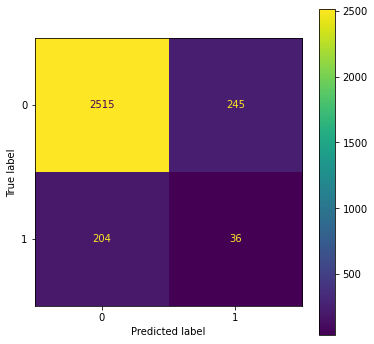

--- ROC AUC ---



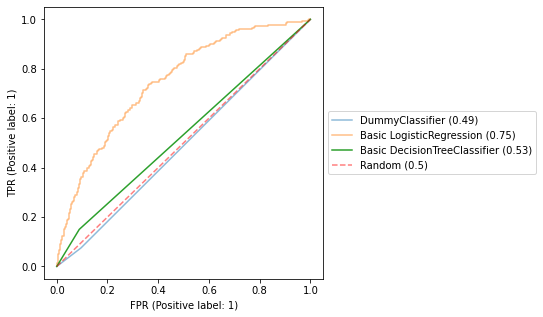

--- PRECISION RECALL AUC ---



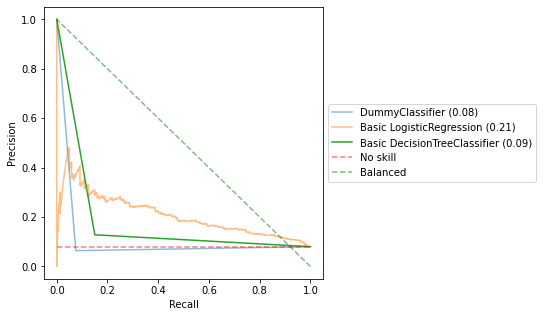

In [44]:
get_scores(f"Basic {get_model_name(grd_dt['model'])}", **grd_dt, register=True)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | f1: 0.0000 | recall: 0.0000 | roc_auc: 0.7054 | accuracy: 0.9200 | average_precision: 0.1811 | precision: 0.0000
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | f1: 0.0000 | recall: 0.0000 | roc_auc: 0.6937 | accuracy: 0.9200 | average_precision: 0.1678 | precision: 0.0000
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | f1: 0.0000 | recall: 0.0000 | roc_auc: 0.6956 | accuracy: 0.9196 | average_precision: 0.1913 | precision: 0.0000
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | f1: 0.0000 | recall: 0.0000 | roc_auc: 0.6986 | accuracy: 0.9198 | average_precision: 0.2006 | precision: 0.0000
----------------------------------------------------

--- Basic RandomForestClassifier ---

                  F1 : 0.0000
              RECALL : 0.0000
             ROC_AUC : 0.7007
            ACCURACY : 0.9198
   AVERAGE_PRECISION : 0.1869
           PRECISION : 0.0000

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



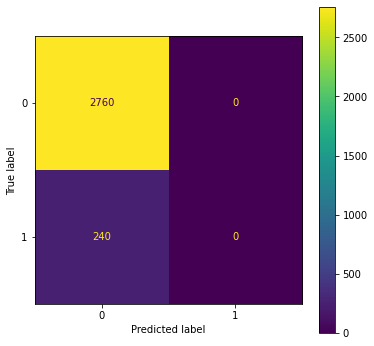

--- ROC AUC ---



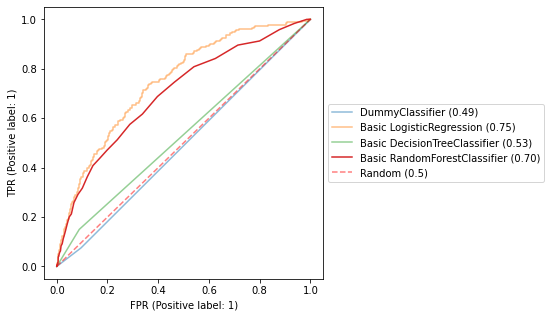

--- PRECISION RECALL AUC ---



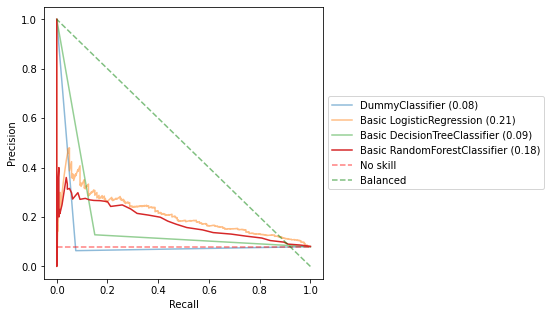

In [47]:
get_scores(f"Basic {get_model_name(grd_rf['model'])}", **grd_rf, register=True)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [48]:
from xgboost import XGBClassifier

In [49]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | f1: 0.0501 | recall: 0.0278 | roc_auc: 0.7133 | accuracy: 0.9157 | average_precision: 0.1856 | precision: 0.2553
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | f1: 0.0502 | recall: 0.0278 | roc_auc: 0.7105 | accuracy: 0.9159 | average_precision: 0.1840 | precision: 0.2609
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | f1: 0.0864 | recall: 0.0485 | roc_auc: 0.6901 | accuracy: 0.9178 | average_precision: 0.1825 | precision: 0.3962
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | f1: 0.0835 | recall: 0.0462 | roc_auc: 0.7120 | accuracy: 0.9187 | average_precision: 0.2070 | precision: 0.4348
----------------------------------------------------

--- Basic XGBClassifier ---

                  F1 : 0.0698
              RECALL : 0.0388
             ROC_AUC : 0.7031
            ACCURACY : 0.9172
   AVERAGE_PRECISION : 0.1887
           PRECISION : 0.3486

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      2760
Prediction = 1       0.25      0.03      0.05       240

      accuracy                           0.92      3000
     macro avg       0.59      0.51      0.50      3000
  weighted avg       0.87      0.92      0.88      3000

--- Confusion Matrix ---



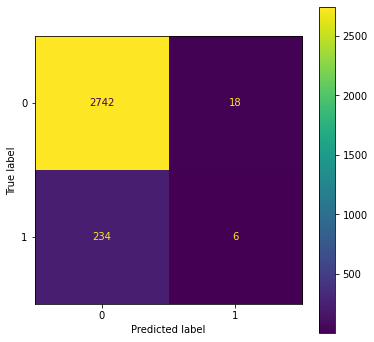

--- ROC AUC ---



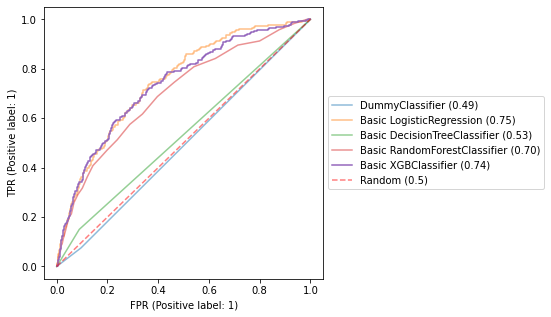

--- PRECISION RECALL AUC ---



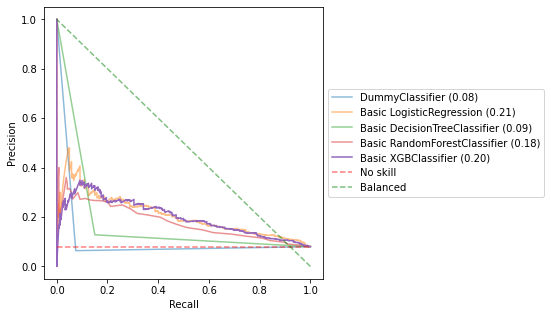

In [50]:
get_scores(f"Basic {get_model_name(grd_xgb['model'])}", **grd_xgb, register=True)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [51]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,0.5,"{'random_state': [0], 'strategy': ['stratified']}",0.500786,0.080441,0.083025,0.850296,0.081514,0.084593,18,2496,264,222,1.384734,0.002878
1,Basic LogisticRegression,0.5,"{'random_state': [0], 'max_iter': [3000]}",0.733725,0.206986,0.028597,0.919556,0.444615,0.014793,0,2756,4,240,109.529117,0.023019
2,Basic DecisionTreeClassifier,0.5,{'random_state': [0]},0.534738,0.088898,0.145246,0.852185,0.135383,0.156724,36,2515,245,204,5.314086,0.011811
3,Basic RandomForestClassifier,0.5,{'random_state': [0]},0.700708,0.186911,0.000000,0.919815,0.000000,0.000000,0,2760,0,240,12.705761,0.101689
4,Basic XGBClassifier,0.5,"{'seed': [0], 'objective': ['binary:logistic']...",0.703102,0.188741,0.069849,0.917222,0.348606,0.038825,6,2742,18,234,44.924909,0.039062


In [52]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']]

,Method,ROC AUC,F1 score,Recall
0,DummyClassifier,0.500786,0.083025,0.084593
1,Basic LogisticRegression,0.733725,0.028597,0.014793
2,Basic DecisionTreeClassifier,0.534738,0.145246,0.156724
3,Basic RandomForestClassifier,0.700708,0.000000,0.000000
4,Basic XGBClassifier,0.703102,0.069849,0.038825


In [53]:
sms.send("Basic done", stop=False)

# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [54]:
param_grid = [
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [ ]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

In [ ]:
grd_log['grid'].best_params_

In [ ]:
get_scores(f"Grid {get_model_name(grd_log['model'])}", **grd_log, register=True)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_dt['grid'].best_params_

In [ ]:
get_scores(f"Grid {get_model_name(grd_dt['model'])}", **grd_dt, register=True)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [ ]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

In [ ]:
grd_rf['grid'].best_params_

In [ ]:
get_scores(f"Grid {get_model_name(grd_rf['model'])}", **grd_rf, register=True)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_xgb['grid'].best_params_

In [ ]:
get_scores(f"Grid {get_model_name(grd_xgb['model'])}", **grd_xgb, register=True)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [ ]:
scores_df

In [ ]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

In [ ]:
sms.send("Gridsearch done", stop=False)

# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [ ]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

In [ ]:
grd_log['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_log['model'])}", **grd_log, register=True)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_dt['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_dt['model'])}", **grd_dt, register=True)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [ ]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

In [ ]:
grd_rf['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_rf['model'])}", **grd_rf, register=True)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [ ]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [ ]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_xgb['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_xgb['model'])}", **grd_xgb, register=True)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [ ]:
scores_df

In [ ]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

In [ ]:
sms.send("Balanced done", stop=False)

# Feature Engineering

In [ ]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

### What fraction of the price of the goods for which the loan is given, represent the credit amount?

In [ ]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [ ]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

### How old was the client when it started his current employement position?

In [ ]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [ ]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

### What fraction of the total incomes per member of the family?

In [ ]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [ ]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

### How many requests overall have been made to the credit bureau?

In [ ]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [ ]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

In [ ]:
data_application_train2 = data_application_train.copy()

In [ ]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

In [ ]:
correlations = data_application_train2.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
data_clean = data_application_train2[:sample_size_base].copy()

In [ ]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [ ]:
#X_train_full, X_test, y_train_full, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.10,
                                                random_state=0,
                                                stratify=Y_full)

### Encoding the qualitative variables

In [ ]:
#oe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() == 2]
#ohe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() > 2]

oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

#### Fit the encoders

In [ ]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [ ]:
#X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train = transform_labels(X_train, oe_model, ohe_model)
#X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [ ]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [ ]:
#X_train_full = impute(X_train_full, imputer_model)
X_train = impute(X_train, imputer_model)
#X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

### Normalizing the dataset

In [ ]:
model_scaler = fit_normalizer(X_train)

In [ ]:
#X_train_full = normalize(X_train_full, model_scaler)
X_train = normalize(X_train, model_scaler)
#X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [ ]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

In [ ]:
grd_log['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_log['model'])} with extra features", **grd_log, register=True)

In [ ]:
#### Let's find the best threshold *(based on F1 score)*

In [ ]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
get_scores(f"Balanced {get_model_name(grd_log['model'])} [w/thresholding & features]", **grd_log, threshold=best_threshold, register=True)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_dt['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_dt['model'])} with extra features", **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [ ]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
get_scores(f"Balanced {get_model_name(grd_dt['model'])} [w/thresholding & features]", **grd_dt, threshold=best_threshold, register=True)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [ ]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

In [ ]:
grd_rf['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_rf['model'])} with extra features", **grd_rf, register=True)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [ ]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [ ]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

In [ ]:
grd_xgb['grid'].best_params_

In [ ]:
get_scores(f"Balanced {get_model_name(grd_xgb['model'])} with extra features", **grd_xgb, register=True)

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

In [ ]:
import FreeMobileSMS as sms
sms.send()